Adding PDFs
====

Investigation into using a PDF to describe the combination of multiple distributions.

Consider two Gaussians $x_1$ and $x_2$:

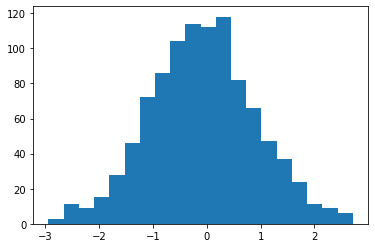

AssertionError: 

In [7]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

rng = np.random.default_rng()


def sample(N, pdf, pdf_domain, pdf_range):
    """
    Use accept-reject sampling to get N samples from pdf
    
    slow
    
    """
    points = np.zeros(N)
    num_generated = 0

    while num_generated < N:
        # Generate a point
        x = pdf_domain[0] + (pdf_domain[1] - pdf_domain[0]) * rng.random()
        y = pdf_range[0] + (pdf_range[1] - pdf_range[0]) * rng.random()

        if y < pdf(x):
            points[num_generated] = x
            num_generated += 1

    return points


std_normal_pdf = lambda x: norm.pdf(x, loc=0, scale=1)
pdf_domain = (-3, 3)
pdf_range = (0, 1)

x = sample(1000, std_normal_pdf, pdf_domain, pdf_range)

plt.hist(x, bins=20)
plt.show()
assert False


kw = {"histtype": "step", "bins": np.linspace(-8, 10, 100)}
plt.hist(x1, **kw, label=r"$x_1$")
plt.hist(x2, **kw, label=r"$x_2$")
plt.hist(np.concatenate((x1, x2)), **kw, label=r"$x_1+x_2$")

plt.legend()
plt.show()

What PDF describes the combination $x_1$ + $x_2$?

From the principles of linearity (?) and scaling (?), the only thing the combined PDF can be is:

$p(x) = I_1p_1(x) + I_2p_2(x)$

Where:

$I_j = \sum_{i=0}^{N_j}\frac{1}{p_1(x_j)}$
